# Science Advances Revisions

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/rigel/home/jb3210/scheduler.json')

In [4]:
client#.restart()

Client Scheduler: tcp://10.43.5.18:8786 Dashboard: http://10.43.5.18:8787,Cluster Workers: 47 Cores: 188 Memory: 945.37 GB


In [5]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline
from xmitgcm import open_mdsdataset
import xgcm

## Variance Budget

We write it like

$$ \frac{\partial}{\partial t} \frac{q^2}{2} + \nabla \cdot \left ( \frac{ \mathbf{u} q^2}{2}  \right )
 - \frac{q^2}{2} \nabla \cdot \mathbf{u} - \nabla \cdot \kappa \nabla \frac{q^2}{2} + \kappa | \nabla q |^2 = 0 $$

In [6]:
def variance_budget(ds_mean, ds_snap, ds_vel, grid, delta_t, kappa):
    q2_uflux = ds_mean.UTrSq * ds_mean.dyG
    q2_vflux = ds_mean.VTrSq * ds_mean.dxG
    div_q2_adv_flux = (grid.diff(q2_uflux, 'X') + grid.diff(q2_vflux, 'Y')) / ds_mean.rA
    
    uvelflux = ds_vel.UVEL * ds_mean.dyG * ds_mean.hFacW
    vvelflux = ds_vel.VVEL * ds_mean.dxG * ds_mean.hFacS
    div_vel_flux = (grid.diff(uvelflux, 'X') + grid.diff(vvelflux, 'Y')) / ds_mean.rA
    # this is only approximate because we didn't save the eddy correlation
    # of q with divergence
    q2_div_vel = ds_mean.TRACSQ * div_vel_flux
    q2_udiff = -kappa * grid.diff(ds_mean.TRACSQ, 'X') / ds_mean.dxC * ds_mean.dyG * ds_mean.hFacW
    q2_vdiff = -kappa * grid.diff(ds_mean.TRACSQ, 'Y') / ds_mean.dyC * ds_mean.dxG * ds_mean.hFacS
    q2_div_diff_flux = (grid.diff(q2_udiff , 'X') + grid.diff(q2_vdiff, 'Y')) / ds_mean.rA
    #
    q2_dissipation = kappa * (grid.interp(ds_mean.DXSqTr * ds_mean.hFacW, 'X') +
                          grid.interp(ds_mean.DYSqTr * ds_mean.hFacS, 'Y'))
    dq2dt = ds_snap.TRACSQ.diff(dim='time') / delta_t
    
    q2_budget = xr.Dataset({'tendency': dq2dt/2,
                        'advection': div_q2_adv_flux/2, 
                        'diffusion': q2_div_diff_flux/2,
                        'dissipation': q2_dissipation,
                        'divergence': -q2_div_vel/2})
    q2_budget['residual'] = (q2_budget.tendency + q2_budget.advection +
                             q2_budget.diffusion + q2_budget.dissipation +
                             q2_budget.divergence)
    return q2_budget

## Eddy Variance Budget

$$ \frac{\partial}{\partial t} \frac{\overline{{q'}^2}}{2}
+ \nabla \cdot \left ( \frac{ \overline{ \mathbf{u} {q'}^2 }}{2}  \right )
 - \overline{\frac{{q'}^2}{2} \nabla \cdot \mathbf{u}}
 + \overline{\mathbf{u}'q'} \cdot \nabla \overline{q} 
 - \nabla \cdot \kappa \nabla \frac{\overline{{q'}^2}}{2}
 + \kappa \overline{ | \nabla q' |^2 } = 0 $$
 
 The overbar is defined as a mean over a number of months and a spatial smoothing by convolution.
 Th time mean is done online. The smoothing we do here.
 Because convolution comutes with time average, it doesn't matter the order we do these operations.

In [7]:
# definie smoothing operator
from astropy.convolution import (convolve, convolve_fft,
                                 Gaussian2DKernel, MexicanHat2DKernel)
# 10 grid points =  1 degree
kernel = Gaussian2DKernel(20)
#kernel = MexicanHat2DKernel(11)
def smooth_raw(data):
    # works on xarray data
    raw_data = getattr(data, 'values', data)
    result = convolve_fft(raw_data, kernel, boundary='wrap')
    result[np.isnan(raw_data)] = np.nan
    return result

mask_vars = {('YC', 'XC'): 'hFacC',
             ('YC', 'XG'): 'hFacW',
             ('YG', 'XC'): 'hFacS'}

def spatial_smoother(data):
    xdim = 'XC' if 'XC' in data.dims else 'XG'
    ydim = 'YC' if 'YC' in data.dims else 'YG'
    dims = (ydim, xdim)
    data_masked = data.where(data[mask_vars[dims]])
    return xr.apply_ufunc(smooth_raw, data_masked,
                          vectorize=True,
                          dask='parallelized',
                          input_core_dims = [dims],
                          output_core_dims = [dims],
                          output_dtypes=[data.dtype])

def eddy_variance_budget(ds_mean, ds_snap, ds_vel, grid , delta_t, kappa):
    qbar = ds_mean.TRAC
    qbar_smooth = spatial_smoother(qbar)
    qp2 = spatial_smoother(ds_mean.TRACSQ) - qbar_smooth**2
    #
    qsnap = ds_snap.TRAC
    qsnap_smooth = spatial_smoother(qsnap)
    qp2_snap = (spatial_smoother(ds_snap.TRACSQ)- qsnap_smooth**2)
    dqp2dt = qp2_snap.diff(dim='time') / delta_t
    #
    # use gad fluxes for higher accuracy
    uq_gad = spatial_smoother(ds_mean.ADVxTr / (ds_mean.drF * ds.dyG)).squeeze()
    vq_gad = spatial_smoother(ds_mean.ADVyTr / (ds_mean.drF * ds.dxG)).squeeze() # These have a z dimension, which is not needed

    ubar = spatial_smoother(ds_vel.UVEL)
    vbar = spatial_smoother(ds_vel.VVEL)
    ubarqbar = ubar * grid.interp(qbar_smooth, 'X')
    vbarqbar = vbar * grid.interp(qbar_smooth, 'Y')
    upqp = uq_gad - ubarqbar
    vpqp = vq_gad - vbarqbar
    div_uq = (  grid.diff(uq_gad * ds_mean.dyG, 'X')
          + grid.diff(vq_gad * ds_mean.dxG, 'Y')) / ds_mean.rA
    #
    # should we apply the smoother again when calculating divergence?
    # hmmm... this is confusing
    div_ubarqbar = (  grid.diff(ubarqbar * ds_mean.dyG, 'X')
                    + grid.diff(vbarqbar * ds_mean.dxG, 'Y')) / ds_mean.rA
    # 
    div_upqp = (  grid.diff(upqp * ds_mean.dyG, 'X')
            + grid.diff(vpqp * ds_mean.dxG, 'Y')) / ds_mean.rA
    #
    # production term
    dqbardx = grid.diff(qbar_smooth, 'X') / ds_mean.dxC * ds_mean.hFacW
    dqbardy = grid.diff(qbar_smooth, 'Y') / ds_mean.dyC * ds_mean.hFacS

    upqp_dqbardx = upqp * dqbardx
    vpqp_dqbardy = vpqp * dqbardy
    # cell centered
    upqp_gradqbar = grid.interp(upqp_dqbardx, 'X') +  grid.interp(vpqp_dqbardy, 'Y')
    #
    # anomaly gradients
    dqpdx2 = spatial_smoother(ds_mean.DXSqTr) - dqbardx**2
    dqpdy2 = spatial_smoother(ds_mean.DYSqTr) - dqbardy**2
    
    dqbardx2 = grid.interp(dqbardx,'X')**2
    dqbardy2 = grid.interp(dqbardy,'Y')**2
    


    qp2_dissipation = kappa * (grid.interp(dqpdx2, 'X') +
                               grid.interp(dqpdy2, 'Y'))
    
    qp2_budget = xr.Dataset({
                            'tendency':  dqp2dt / 2,
                            'production': upqp_gradqbar, 
                            'dissipation': qp2_dissipation,
                            'qbar_variance': dqbardx2 + dqbardy2,
                            'qp_variance': qp2 / 2})
    qp2_budget['koc'] = qp2_budget.dissipation / qp2_budget.qbar_variance
    return qp2_budget

In [8]:
from aviso_surface_tracer import convert_trnum2dimension
# # convert tracer fields for both tracers into a dim
# def convert_trnum2dimension(ds):
#     def drop_nonmatching_vars(ds, var_list):
#         data_vars = list(ds.data_vars)
#         drop_vars = [a for a in data_vars if a not in var_list]
#         return ds.drop(drop_vars)
    
#     def rename_vars(ds):
#         for vv in list(ds.data_vars):
#             ds = ds.rename({vv:vv[0:-2]})
#         return ds
        
#     tr_num = list(set([a[-2:] for a in list(ds.data_vars)]))
#     tr_num.sort()
#     tr_vars = list(set([a[:-2] for a in list(ds.data_vars)]))
    
#     datasets = [drop_nonmatching_vars(ds, [a+n for a in tr_vars]) for n in tr_num]
#     datasets = [rename_vars(b) for b in datasets]
    
#     tr_num_int = [int(a) for a in tr_num]
    
#     tr_dim = xr.DataArray(tr_num_int, 
#                           dims='tracer_no',
#                           coords={'tracer_no': (['tracer_no', ], tr_num_int)})
    
#     ds_combined = xr.concat(datasets,dim='tracer_no')
#     ds_combined['tracer_no'] = tr_dim
    
#     return ds_combined

In [9]:
def reset_cut(reset_frq, reset_pha, dt_model, dt_tracer, iters, cut_time):
    """
    determine the timing of reset and define cut index
    Based on the information in the modelparameters this routine translates
    the reset time in second to iterations and constructs an index, matching
    a passed array which can then be used as a mask
    Input:  reset_frq - frequency of reset in seconds
            reset_pha - phase of reset in seconds
            dt_model - timestep of model in seconds
            dt_tracer - timestep of tracer output
            iters - numpy array of iterations on which index is constructed
            cut_time = [in seconds] time after (before; if negative number)
            the reset that should be masked by
    Output: mask -
            reset_iters -
            reset_time -
    """
    reset_time = np.array(range(reset_pha,
                                (iters.max()*dt_model)+dt_model,
                                reset_frq),
                          dtype=int)

    # iteration 0 is always considered a reset
    if not reset_time[0] == 0:
        reset_time = np.concatenate((np.array([0]), reset_time))

    # ceil the values if reset times dont divide without remainder
    # That way for snapshots the reset is evaluating the first snapshot
    # after the reset and for averages it ensures that the 'reset average'
    # contains the actual reset time
    reset_iters = np.ceil(reset_time/float(dt_model))
    # round iters to nearest tracer iters
    tracer_iters = float(dt_tracer)/float(dt_model)
    reset_iters = np.ceil(reset_iters/tracer_iters)*tracer_iters
    # remove iters that are bigger then iter max
    while reset_iters[-1] > iters.max():
        reset_iters = reset_iters[0:-1]

    # translate cut time to iters (round down)
    cut = np.ceil(cut_time/float(dt_model))
    mask = np.ones_like(iters)
    for ii in reset_iters:
        if cut_time < 0:
            idx = np.logical_and(iters > (ii+cut), iters <= ii)
        else:
            idx = np.logical_and(iters >= ii, iters < (ii+cut))
        mask[idx] = 0
    return mask, reset_iters, reset_time

def paramReadout(directory):
    # TODO write test
    '''cheap implementation to read out the data* files from mitgcm dir'''
    directory
    params = dict(check=[])
    for dfile in ['data', 'data.ptracers', 'data.diagnostics']:
        for line in open(directory+dfile):
            if '&' not in line and '#' not in line and '\n' not in line[0]:
                line_out = (line.replace('\n', '')
                            .replace(' ', '')
                            .split('=')
                            )
                if len(line_out) == 2 and len(line_out[1]) > 1:
                    while line_out[1][-1] in ['.', ',']:
                        line_out[1] = line_out[1][0:-1]
                        while line_out[1][-1] in ['.', ',']:
                            line_out[1] = line_out[1][0:-1]
                    params[dfile+'/'+line_out[0]] = line_out[1]
    return params

def reset_mask(params, ds, cut_time):
    """Creates a mask to cut out the time after tracer reset for a length of cut_time (seconds).
    This reads the model parameters from the namefiles (data*) directly from params"""
    iters = ds.iter.data
    tracernum = np.arange(int(params['data.ptracers/PTRACERS_numInUse']))+1
    dt_model = int(float(params['data/deltaTtracer']))
    total_iters_model = int(float(params['data/nTimeSteps']))
    
    reset_masks = []
    for tr in tracernum:
        freq = int(params['data.ptracers/PTRACERS_resetFreq('+str(tr)+')'])
        phase = int(params['data.ptracers/PTRACERS_resetPhase('+str(tr)+')'])
        dt_tracer = abs(int(float(params['data.diagnostics/frequency('+str(tr)+')'])))
        mask, reset_iters, reset_time = reset_cut(freq, phase, dt_model, dt_tracer, iters, cut_time)
        da_mask = ds['time'].copy()
        da_mask = da_mask.rename('reset_mask')
        da_mask.data = mask
        da_mask.coords['time'].data = ds['time'].data
        reset_masks.append(da_mask)
    return xr.concat(reset_masks, ds['tracer_no'])

#TODO:
# Stack the tracer budget according to reset ...with that we can quantify when the budget'spun up'
# def model_params(params):
    
# TODO: rewrite the functions so I can easily use them in other model setups

In [10]:
ddir = '/rigel/ocp/users/jb3210/projects/aviso_surface_tracer/runs'
# run = 'run_KOC_PSI_variance_budget_new' #interrupted at t=163 # Finished
# run = 'run_KOC_LAT_variance_budget_new' # This went straight through
# run = 'run_KOC_SST_variance_budget_new' # This aswell
run = 'run_KOC_SSS_variance_budget_new'
rundir = os.path.join(ddir,run)
odir = os.path.join(ddir,run,'output_new')
if not os.path.isdir(odir):
    os.mkdir(odir)
timestep = 900 # in seconds
kappa = 63

In [11]:
ds = open_mdsdataset(rundir, prefix=['tracer_diags'],
                     delta_t=timestep)#, ref_date='1993-01-01')
ds = convert_trnum2dimension(ds)
ds

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:    (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 292, tracer_no: 2)
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG         (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG         (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 ...
  * Z          (Z) float32 -50.0
  * Zp1        (Zp1) float32 0.0 -100.0
  * Zu         (Zu) float32 -100.0
  * Zl         (Zl) float32 0.0
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    dxG        (YG, XC) float32 1930.58 1930.58 1930.58 1930.58 1930.58 ...
    dyG        (YC, XG) float32 11117.7 11117.7 11117.7 11117.7 11117.7 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rAz        (YG, XG) float32 2.14637e+07 2.14637e+07 2.14637e+07 

In [12]:
ds_vel = open_mdsdataset(rundir, prefix=['vel_diags'],
                     delta_t=timestep)#, ref_date='1993-01-01')
ds_vel

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 292)
Coordinates:
  * XC       (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 ...
  * YC       (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG       (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG       (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 -79.2 ...
  * Z        (Z) float32 -50.0
  * Zp1      (Zp1) float32 0.0 -100.0
  * Zu       (Zu) float32 -100.0
  * Zl       (Zl) float32 0.0
    rA       (YC, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    dxG      (YG, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    dyG      (YC, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    Depth    (YC, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    rAz      (YG, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    dxC      (YC, XG) >f4

In [13]:
ds_snap = open_mdsdataset(rundir, prefix=['tracer_snapshots'],
                          delta_t=timestep)#, ref_date='1993-01-01')
ds_snap = convert_trnum2dimension(ds_snap)
ds_snap

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:    (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 293, tracer_no: 2)
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG         (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG         (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 ...
  * Z          (Z) float32 -50.0
  * Zp1        (Zp1) float32 0.0 -100.0
  * Zu         (Zu) float32 -100.0
  * Zl         (Zl) float32 0.0
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    dxG        (YG, XC) float32 1930.58 1930.58 1930.58 1930.58 1930.58 ...
    dyG        (YC, XG) float32 11117.7 11117.7 11117.7 11117.7 11117.7 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rAz        (YG, XG) float32 2.14637e+07 2.14637e+07 2.14637e+07 

In [14]:
# reused input for all budgets
delta_t = ds.iter[0].values*timestep
grid = xgcm.Grid(ds)
grid

<xgcm.Grid>
T Axis (periodic):
  * center   time (292)
Z Axis (periodic):
  * center   Z (1) --> left
  * left     Zl (1) --> center
  * outer    Zp1 (2) --> center
  * right    Zu (1) --> center
Y Axis (periodic):
  * center   YC (1600) --> left
  * left     YG (1600) --> center
X Axis (periodic):
  * center   XC (3600) --> left
  * left     XG (3600) --> center

In [15]:
params = paramReadout(rundir+'/')
cut_time = (1*30*24*60*60)+1
mask = reset_mask(params, ds, cut_time).astype(bool)
print(mask.time)
mask.to_netcdf(os.path.join(odir,'reset_mask.nc'))

<xarray.DataArray 'time' (time: 292)>
array([  2592000,   5184000,   7776000, ..., 751680000, 754272000, 756864000])
Coordinates:
    iter     (time) int64 2880 5760 8640 11520 14400 17280 20160 23040 25920 ...
  * time     (time) int64 2592000 5184000 7776000 10368000 12960000 15552000 ...
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
    units:          seconds
    calendar:       gregorian


In [16]:
for d in ['ds', 'ds_snap', 'ds_vel']:
    print(d, eval('%s.nbytes/1e9' %d))

ds 161.740846332
ds_snap 27.279406348
ds_vel 27.187246316


In [17]:
ds = ds.persist()
ds_snap_raw = ds_snap.persist()
ds_vel = ds_vel.persist()

# Write out Eddy budget files due to mysterious cluster failures

In [18]:
qp2_budget_raw = eddy_variance_budget(ds, ds_snap, ds_vel, grid, delta_t, kappa=kappa)
print(qp2_budget_raw)

# print(qp2_budget_raw.isel(time=2).load())

t_range = range(160, len(qp2_budget_raw.time))
for ti in t_range:
    print(ti)
    qp2_budget_raw.isel(time=ti).load().to_netcdf(os.path.join(odir,'%04i_global_eddytracervar_budget.nc' %ti))

<xarray.Dataset>
Dimensions:        (XC: 3600, YC: 1600, time: 292, tracer_no: 2)
Coordinates:
  * tracer_no      (tracer_no) int64 1 2
  * XC             (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 ...
  * YC             (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
    rA             (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter           (time) int64 2880 5760 8640 11520 14400 17280 20160 23040 ...
  * time           (time) int64 2592000 5184000 7776000 10368000 12960000 ...
Data variables:
    tendency       (tracer_no, time, YC, XC) float64 dask.array<shape=(2, 292, 1600, 3600), chunksize=(1, 1, 1600, 3600)>
    production     (tracer_no, time, YC, XC) float32 dask.array<shape=(2, 292, 1600, 3600), chunksize=(1, 1, 1600, 3600)>
    dissipation    (tracer_no, time, YC, XC) float3

distributed.utils - ERROR - ('getitem-fd20afbfd86c0f7186b694e10e20cebc', 1, 0, 0)
Traceback (most recent call last):
  File "/rigel/home/jb3210/code/miniconda/envs/standard/lib/python3.6/site-packages/distributed/client.py", line 1305, in _gather
    st = self.futures[key]
KeyError: "('getitem-fd20afbfd86c0f7186b694e10e20cebc', 1, 0, 0)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/rigel/home/jb3210/code/miniconda/envs/standard/lib/python3.6/site-packages/distributed/utils.py", line 238, in f
    result[0] = yield make_coro()
  File "/rigel/home/jb3210/code/miniconda/envs/standard/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/rigel/home/jb3210/code/miniconda/envs/standard/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/rigel/home/jb3210/code/miniconda/en

CancelledError: ('getitem-fd20afbfd86c0f7186b694e10e20cebc', 1, 0, 0)

# First Quality Control

In [99]:
trsq_snap = ds_snap.TRACSQ.mean(dim=['YC', 'XC']).load()
trsq_snap_diff = trsq_snap.diff(dim='time')

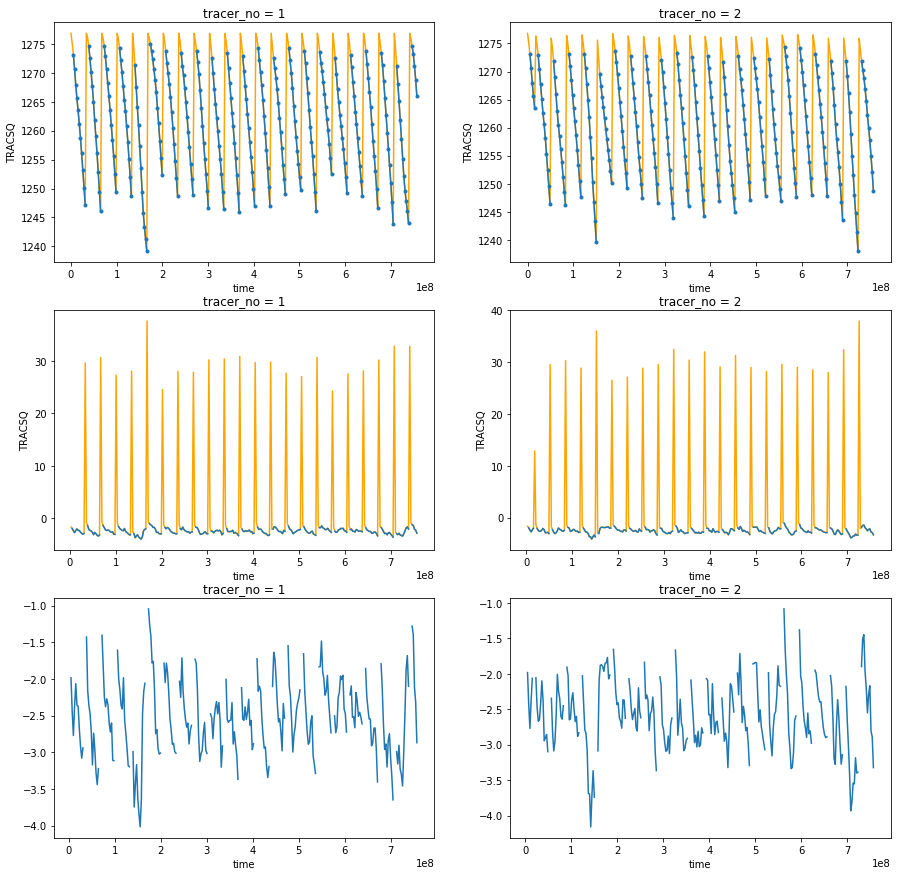

In [100]:
plt.figure(figsize=[15,15])
for tr in trsq_snap.tracer_no.data:
    plt.subplot(3,2,tr)
    trsq_snap.sel(tracer_no=tr).plot(color='orange')
    trsq_snap.where(mask).sel(tracer_no=tr)[1:].plot(marker='.')

    plt.subplot(3,2,tr+2)
    trsq_snap_diff.sel(tracer_no=tr).plot(color='orange')
    trsq_snap_diff.where(mask).sel(tracer_no=tr).plot()
    
    plt.subplot(3,2,tr+4)
    trsq_snap_diff.where(mask).sel(tracer_no=tr).plot()

# Why is the tracer variance increasing for the SSS?

In [108]:
it seems that the salinity in the smaller basins (Caspian, Black Sea, Med) messes up the global variance budget...
I will try to use the validmask...but I am not sure if that is completely right...

# test = ds_snap.TRACSQ.isel(tracer_no=0).diff('time').load()

# caspian_sea_mask = xr.ufuncs.logical_and(xr.ufuncs.logical_and(test.YC>35, test.YC<=55),
#                                          xr.ufuncs.logical_and(test.XC>45, test.XC<=60))
# # caspian_sea_mask.plot()
# # test.isel(time=12).where(~caspian_sea_mask).plot(robust=True)
# test.isel(time=14).plot(robust=True)

# test_clean = (ds_snap.TRACSQ.isel(tracer_no=0).diff('time').where(~caspian_sea_mask) * ds_snap.rA).sum(['XC', 'YC']).load()

# test_clean.plot()

# Save out globally averaged tracer budget

In [144]:
# raw indicates that kappa is set to 1 so we can diagnose it from the globally integrated variance budget
q2_budget_raw = variance_budget(ds, ds_snap, ds_vel, grid, delta_t=delta_t, kappa=1)
q2_budget_raw

# Diagnose the globally integrated numerical diffusivity (Abandoned the idea due to problems with small basins MEd, Caspian)

# q2_budget_raw_integrated = (q2_budget_raw * q2_budget_raw.rA * q2_budget_raw.hFacC).sum(['XC','YC'])
# print(q2_budget_raw_integrated)
# print(q2_budget_raw_integrated.isel(time=149).load())

# t_range = range(len(q2_budget_raw_integrated.time))
# for ti in t_range:
#     print(ti)
#     q2_budget_raw_integrated.isel(time=ti).load().to_netcdf(os.path.join(odir,'%04i_global_int_tracervar_budget.nc' %ti))

In [23]:
# # to analysis script
# diagnosed_kappa = -(q2_budget_raw_integrated.tendency / q2_budget_raw_integrated.dissipation)
# diagnosed_kappa1 = diagnosed_kappa.sel(tracer_no=1).load()
# diagnosed_kappa1 = diagnosed_kappa.sel(tracer_no=2).load()

In [39]:
region = {'XC':slice(200, 250), 'YC': slice(-40,-20)}
test = qp2_dissipation.mean(dim=['XC', 'YC']).persist()
test

<xarray.DataArray (tracer_no: 2, time: 292)>
dask.array<shape=(2, 292), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...

In [1]:
test.isel(tracer_no=0).plot()

NameError: name 'test' is not defined

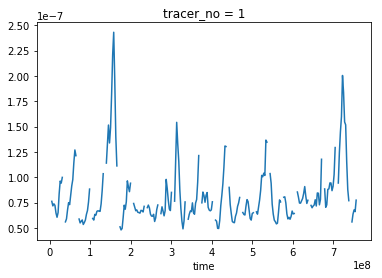

In [42]:
# Compare a timeseries of dissipation estimates
region = {'XC':slice(200, 250), 'YC': slice(-40,-20)}
tr_kw = {'tracer_no':0}
mask_tr = mask.isel(**tr_kw)

plt.figure()
qp2_dissipation.isel(**tr_kw).sel(**region).mean(dim=['XC',
                                                      'YC']).where(mask_tr).plot()

In [ ]:
region = {'XC':slice(200, 250), 'YC': slice(-40,-20)}
plt.figure()
upqp_gradqbar.where(mask).sel(**region).mean(dim=['XC', 'YC','tracer_no']).plot()

In [ ]:
mask

In [ ]:

KOC

In [ ]:
KOC.mean(['time','tracer_no']).plot()

In [ ]:
plt.figure()
(KOC).sel(**region).mean(dim=['tracer_no', 'XC', 'YC']).plot()

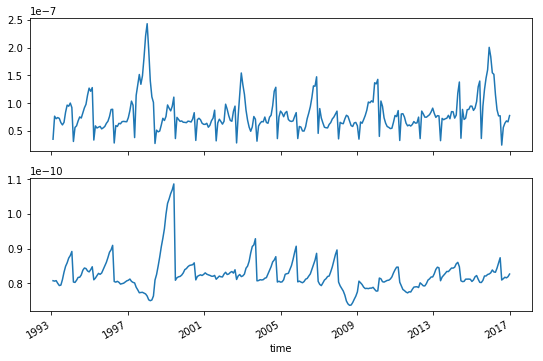

In [83]:
plt.subplot(2,1,1)
qp2_dissipation.sel(**region).mean(dim=['XC', 'YC']).plot()
plt.subplot(2,1,2)
Background_GradVar.sel(**region).mean(dim=['XC', 'YC']).plot()

In [ ]:
upqp_gradqbar[3:6].mean(dim='time').plot(vmax=1e-9)
plt.title('production')

In [ ]:
resid = qp2_dissipation + upqp_gradqbar
resid[3:6].mean(dim='time').plot(vmax=1e-9)
plt.title('residual (3 month average, 20-point std dev)')

In [ ]:
frac = (abs(resid[3:6].mean(dim='time')) / qp2_dissipation[3:6].mean(dim='time')).load()

In [ ]:
frac = frac.squeeze()
frac

In [ ]:
frac.plot(vmax=2, vmin=0, cmap='PiYG')
plt.title('Fraction of Residual to Dissipation')

In [ ]:
frac

In [ ]:
frac.plot.contourf(levels=[0,0.5,1])
plt.title('Fraction of Residual to Dissipation')

In [ ]:
# Calculate Osborn-Cox


In [ ]:
upqp[2].sel(XG=slice(150,200), YC=slice(20,50)).plot()

In [ ]:
vpqp[2].sel(XC=slice(150,200), YG=slice(20,50)).plot()

In [ ]:
vq_gad[2].sel(XC=slice(150,200), YG=slice(-20, 20)).plot()

In [ ]:
dqbardy[2].sel(XC=slice(150,200), YG=slice(-20,20)).plot()

In [ ]:
vq_gad.mean(dim='time').sel(XC=slice(150,200), YG=slice(-20, 20)).plot()

In [ ]:
dqbardy.mean(dim='time').sel(XC=slice(150,200), YG=slice(-20,20)).plot()